### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *
import sqlite3
from sqlite3 import Error

In [3]:
#make sure your path is set to source folder
%cd /home

/home


In [4]:
!pwd

/home


In [5]:
# Setting up all directory
root_folder = "/home/Assignment/02_training_pipeline/notebooks/"
data_directory = root_folder+"Data/"

print("directory loaded")

directory loaded


 ### 2 Reading Data

In [6]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv(data_directory+'cleaned_data.csv')

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 19.6 µs


In [7]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [8]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

In [9]:
dataset.columns

Index(['city_tier', 'first_platform_c', 'first_utm_medium_c',
       'first_utm_source_c', 'total_leads_droppped', 'referred_lead',
       'app_complete_flag', 'assistance_interaction', 'career_interaction',
       'payment_interaction', 'social_interaction', 'syllabus_interaction'],
      dtype='object')

### 3 Setting up Environment: 

In [10]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location

db_file="lead_scoring_model_experimentation.db"

import sqlite3
from sqlite3 import Error

def create_sqlit_connection(root_folder,db_file):
    """ create a database connection to a SQLite database """
    conn = None
    # opening the conncetion for creating the sqlite db
    try:
        conn = sqlite3.connect(root_folder+db_file)
        print(sqlite3.version)
    # return an error if connection not established
    except Error as e:
        print(e)
    # closing the connection once the database is created
    finally:
        if conn:
            conn.close()

            
create_sqlit_connection(root_folder,r"lead_scoring_model_experimentation.db")

2.6.0


In [10]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\n'

In [11]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [11]:
# setup pycaret 
#!pip install pycaret

### 4 : Model Experimentation with pycaret

In [12]:
# create a experimentation with pycaret 
Baseline_model_exp01 = setup(data = dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='Baseline_model_exp01',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [14]:
#!pip install optuna==2.10.1

In [15]:
# create a model which gives the highest accuracy
excluded_models = ['gbc','knn','qda', 'dummy', 'svm', 'ada']

# Compare only the models that are not in the excluded list and sort by Accuracy
best_model = compare_models(sort = 'Accuracy',fold = 5,exclude = excluded_models)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7386,0.8211,0.8343,0.7020,0.7624,0.4765,0.4854,1.1960
xgboost,Extreme Gradient Boosting,0.7384,0.8211,0.8321,0.7025,0.7618,0.4762,0.4847,9.9120
rf,Random Forest Classifier,0.7373,0.8185,0.8228,0.7044,0.7590,0.4741,0.4811,3.1340
et,Extra Trees Classifier,0.7367,0.8176,0.8210,0.7044,0.7582,0.4729,0.4797,4.0280
dt,Decision Tree Classifier,0.7364,0.8166,0.8205,0.7041,0.7579,0.4723,0.4789,0.2260
lr,Logistic Regression,0.7098,0.7836,0.8222,0.6731,0.7402,0.4189,0.4297,2.4360
ridge,Ridge Classifier,0.7005,0.0000,0.7962,0.6702,0.7278,0.4003,0.4077,0.1700
lda,Linear Discriminant Analysis,0.7005,0.7733,0.7961,0.6702,0.7277,0.4003,0.4077,0.4560
nb,Naive Bayes,0.6629,0.7335,0.8924,0.6134,0.7269,0.3241,0.3653,0.5700


In [16]:
best_model = finalize_model(best_model)

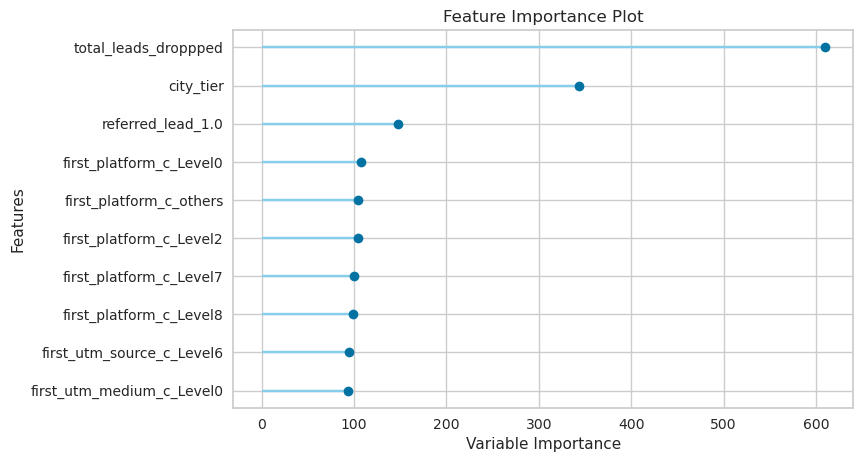

In [17]:
# create feature importance plot
%matplotlib inline
plot_model(estimator = best_model, plot = 'feature')


### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [18]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.
# create a experimentation with pycaret 
Baseline_model_exp02 = setup(data = dataset, target = 'app_complete_flag', 
                   session_id = 40,fix_imbalance=False,
                   ignore_features=['assistance_interaction', 'career_interaction','payment_interaction', 'social_interaction', 'syllabus_interaction'],
                   n_jobs=-1,use_gpu=False,
                   normalize=False,transformation=False,
                   log_experiment=True,experiment_name='Baseline_model_exp02',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,40
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [19]:
# create a model which gives the highest accuracy
# Compare only the models that are not in the excluded list and sort by Accuracy
new_best_model = compare_models(sort = 'Accuracy',fold = 5,exclude = excluded_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7388,0.8208,0.8314,0.7030,0.7618,0.4771,0.4854,8.3940
lightgbm,Light Gradient Boosting Machine,0.7384,0.8210,0.8358,0.7011,0.7625,0.4763,0.4855,1.1720
rf,Random Forest Classifier,0.7375,0.8182,0.8227,0.7045,0.7590,0.4746,0.4815,2.9860
et,Extra Trees Classifier,0.7364,0.8171,0.8190,0.7045,0.7574,0.4724,0.4789,3.6800
dt,Decision Tree Classifier,0.7363,0.8164,0.8186,0.7045,0.7573,0.4722,0.4786,0.1860
lr,Logistic Regression,0.7096,0.7844,0.8219,0.6727,0.7399,0.4186,0.4294,0.7420
ridge,Ridge Classifier,0.7008,0.0000,0.7965,0.6702,0.7279,0.4010,0.4084,0.0860
lda,Linear Discriminant Analysis,0.7006,0.7727,0.7963,0.6701,0.7277,0.4007,0.4081,0.3600
nb,Naive Bayes,0.6753,0.7339,0.8547,0.6305,0.7257,0.3494,0.3742,0.0880


In [20]:
#You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret

#selecting the LGBM considering overall performance(F1 score highest)
lgbm  = create_model('lightgbm', fold = 5) 

In [21]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
tuned_lgbm_optuna,tuner_1 = tune_model(lgbm, 
                                    search_library='optuna',
                                    search_algorithm='random',
                                    fold = 10,
                                    optimize = 'AUC',
                                    choose_better=True,
                                    return_tuner=True)

In [23]:
# Print the final models configuration so that we can use it in the model retraining pipeline
print(tuner_1)

OptunaSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
               enable_pruning=False, error_score='raise',
               estimator=Pipeline(memory=None,
                                  steps=[('empty_step', 'passthrough'),
                                         ('actual_estimator',
                                          LGBMClassifier(boosting_type='gbdt',
                                                         class_weight=None,
                                                         colsample_bytree=1.0,
                                                         importance_type='split',
                                                         learning_rate=0.1,
                                                         max_depth=-1,
                                                         min_child_sam...
                                    'actual_estimator__reg_alpha': LogUniformDistribution(high=10.0, low=1e-10),
                             